# HW2 : Filtres : pôles et zéros, représentation temporelle et fréquentielle

## Introduction

Les filtres peuvent être représentés par leurs pôles et zéros, ainsi que par leur réponse fréquentielle et leur réponse impulsionnelle.

Dans ce homework, vous allez être amenés à représenter un petit nombre de filtres par ces méthodes.  On vous demande, en particulier, de pouvoir expliquer clairement les relations entre ces différentes représentation pour les filtres donnés.

Dans la cellule suivante, on vous procure une fonction qui trace le diagramme des pôles et zéros, qui vous sera utile.  Enfin, on vous donne un exemple dans le paragraphe 


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 20 09:34:01 2018

@author: deneire
"""

# -*- coding: utf-8 -*-
"""
Combination of
http://scipy-central.org/item/52/1/zplane-function
and
http://www.dsprelated.com/showcode/244.php
with my own modifications
"""

# Copyright (c) 2011 Christopher Felton
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even thpwde implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.


# The following is derived from the slides presented by
# Alexander Kain for CS506/606 "Special Topics: Speech Signal Processing"
# CSLU / OHSU, Spring Term 2011.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from matplotlib import patches
from matplotlib.pyplot import axvline, axhline
from collections import defaultdict
from scipy import signal
from scipy.signal import (freqz, butter, bessel, cheby1, cheby2, ellip,
                          tf2zpk, zpk2tf, lfilter, buttap, bilinear, cheb2ord, cheb2ap
                          )
from numpy import asarray, tan, array, pi, arange, cos, log10, unwrap, angle
from matplotlib.pyplot import (stem, title, grid, show, plot, xlabel,
                              ylabel, subplot, xscale, figure, xlim,margins)



#   Treats the case of multiple zeros or poles
#   it transforms a list of zeros (or poles) in a list of zeros (or poles)
#   with their multiplicity
#   For example : 
#          z=np.array([1,1,0,4])
#          print(detmult(z))
#   will yield :
#   [[1 2]              #  (1 with multiplicity 2)
#    [0 1]              #  (0 with multiplicity 1)
#    [4 1]]             #  (4 with multiplicity 1)

def detmult(z):
    s=np.size(z)
    mark=np.zeros(s)
    i=0
    inter=(np.abs(z-z[i])<1e-5)*1.0
    multinter=np.sum(inter)
    mark=mark+inter*multinter
    mult=[[z[i],int(multinter)]]
    
    while i < s :
        i=i+1
        if (i<s) and (mark[i]==0):
            inter=(np.abs(z-z[i])<1e-5)*1.0
            multinter=np.sum(inter)
            mark=mark+inter*multinter
            mult=np.concatenate((mult,[[z[i],int(multinter)]]))
        
    
    return np.array(mult)
    
    
#  Plots the z plane with
#          z : an array with the zeroes 
#          p : an array with the poles
#          ax : the figure on which to plot
    
def zplane(z, p, ax):
    """Plot the complex z-plane given zeros and poles.
    """

 
    unit_circle = patches.Circle((0,0), radius=1, fill=False,
                                 color='black', ls='solid', alpha=0.1)
    ax.add_patch(unit_circle)
    axvline(0, color='0.7')
    axhline(0, color='0.7')

    # Scale axes to fit
    r = 1.5 * np.amax(np.concatenate((np.abs(z), np.abs(p), [1])))
    plt.axis('scaled')
    plt.axis([-r, r, -r, r])
    multz=detmult(z)
    multp=detmult(p)
    nz,throw=multz.shape
    npo,throw=multp.shape
    for i in np.arange(nz):
        plt.plot(multz[i,0].real,multz[i,0].imag,'o',markersize=9,
                 color='b',alpha=0.5)
        if multz[i,1]>1:
            plt.text(multz[i,0].real+r*0.03,multz[i,0].imag+r*0.03,int(multz[i,1]))
    for i in np.arange(npo):
        plt.plot(multp[i,0].real,multp[i,0].imag,'x',markersize=9,
                 color='b',alpha=0.5)
        if multp[i,1]>1:
            plt.text(multp[i,0].real+r*0.03,multp[i,0].imag+r*0.03,int(multp[i,1]))


def sysplots(z,p,gain,nimp,numfig):

    #  Defines a discrete time system (dt=1) given the list of zeros, poles and a gain
    sys=signal.ZerosPolesGain(z, p, gain, dt=1)
    
    # Create zero-pole plot
    f=plt.figure(numfig)
    plt.clf()
    ax=plt.subplot(1, 1, 1)
    zplane(z, p,ax)
    grid(True, color='0.9', linestyle='-', which='both', axis='both')
    title('Poles and zeros')
    
    
    # Impulse response
    f=plt.figure(numfig+1)
    plt.clf()
    index,y = signal.dimpulse(sys,n=nimp)
    stem(index,y[0], use_line_collection=True)
    title('Impulse response')
    margins(0, 0.1)
    grid(True, color='0.9', linestyle='-', which='both', axis='both')
    show()

    # Frequency response
    f=plt.figure(numfig+2)
    plt.clf()
    w, h = signal.dfreqresp(sys)
    plot(w/pi/2, abs(h))
    
    title('Frequency response')
    xlabel('Normalized frequency')
    ylabel('Amplitude ')
    margins(0, 0.1)
    grid(True, color = '0.7', linestyle='-', which='major', axis='both')
    grid(True, color = '0.9', linestyle='-', which='minor', axis='both')
    show()
    
    # Phase
    f=plt.figure(numfig+3)
    plt.clf()
    plot(w/pi/2,  unwrap(angle(h)))
    xlabel('Normalized frequency')
    ylabel('Phase [Radians]')
    grid(True, color = '0.7', linestyle='-', which='major')
    grid(True, color = '0.9', linestyle='-', which='minor')
    show()


## Un petit exemple

Ci-dessous, un petit exemple utilisant les fonctions fournies.  Vous considérez l'exemple de cinq zéros équirépartis à 60 degrés sur le cercle unité, en exceptant le zéro à 0 degrés.  On obtient donc bien la figure "poles and zeros" ci-dessous.

### Réponse fréquentielle en magnitude
Commençons par interpréter la troisième figure, qui représente la magnitude de la réponse en fréquence.

Pour vérifiez que cette réponse fréquentielle correspond bien au diagramme des pôles et zéros, reprenons la méthode graphique qui permet d'estimer la magnitude de la réponse fréquentielle.  A la fréquence 0 ($\omega =0$), la magnitude est égale au produit des distances du point (1,0) dans le plan $z$ aux zéros.  Le premier zéro est en $e^{j 2 \pi /6}$, soit les coordonnées ($\cos(\pi/3), \sin(\pi/3)$).  Le deuxième zéro est aux coordonnées ($\cos(2 \pi/3), \sin(2 \pi/3)$), et le troisième zéro est aux coordonnées $(-1,0)$.  La magnitude est donc (en 
prenant en compte que l'on a deux paires de zéros complexes conjugés) égale à d1 * d2 * d3 * d2 * d1 = 6.0.  Cela correspond bien à la réponse fréquentielle tracée en $f=0$.

Ensuite, on a, toujours en se souvenant que la magnitude est égale au produit des distances du point correspondant à $\omega$ dans le plan $z$ aux zéros, pour le premier zéro, une valeur nulle à $\omega = \displaystyle \frac{\pi}{3} = 0$, correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.1666$, ce qui correspond  bien au tracé fourni.  On peut faire le même constat à $f=0.3333$ et $f=0.5$.  Le filtre étant réel, la réponse fréquentielle est symétrique en magnitude (ce qui est cohérent avec le fait que les zéros sont complexes conjugués).

### Réponse fréquentielle en phase
Comme on l'a vu dans le chapitre sur les systèmes LTI, la réponse impulsionnelle étant symétrique (à un décalage près), la phase de la réponse fréquentielle est linéaire.

### Réponse impulsionnelle
On se souvient que la réponse fréquentielle est également la transformée de Fourier (à temps discrèt) de la réponse impulsionnelle du filtre.  La réponse impulsionnelle est donc la DTFT inverse de la réponse fréquentielle.  

Observons donc la réponse fréquentielle.  Elle a un maximum en $f=0$, correspondant à un signal continu (en anglais : DC - Direct Current), suivi de quelques oscillations.  C'est donc cohérent avec le fait d'avoir une constante pour $n= 0, ... 5$ (on se convainc d'ailleurs facilement que $H(0) =6$ en reprenant la définition de la DTFT (= $\sum_{n=0}^5 1 . e^{\jmath 0}$)).


premier zéro de coordonnées 0.5000000000000001 0.8660254037844386
distance à (1,0) =  0.9999999999999999
deuxième zéro de coordonnées -0.4999999999999998 0.8660254037844388
distance à (1,0) =  1.7320508075688772
magnitude =  5.999999999999997


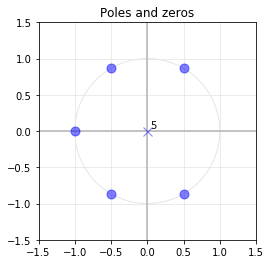

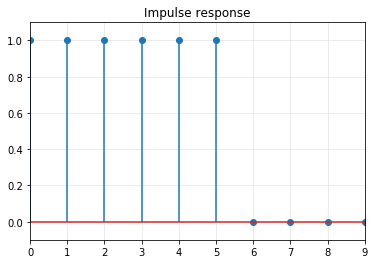

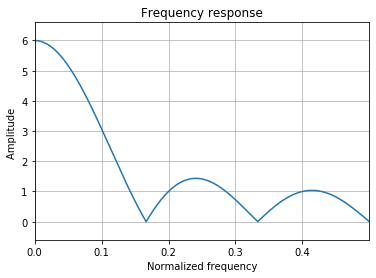

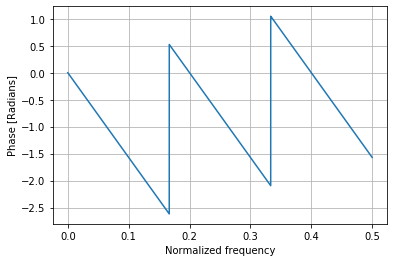

In [3]:
print('premier zéro de coordonnées', np.cos(np.pi/3), np.sin(np.pi/3))
d1=np.sqrt((1-np.cos(np.pi/3))**2+ np.sin(np.pi/3)**2)
print('distance à (1,0) = ', d1)
print('deuxième zéro de coordonnées', np.cos(2*np.pi/3), np.sin(2*np.pi/3))
d2=np.sqrt((1-np.cos(2*np.pi/3))**2+ np.sin(2*np.pi/3)**2)
print('distance à (1,0) = ', d2)
d3=2
print('magnitude = ',d1*d2*d3*d2*d1)


zp=[[-1,np.exp(1j*2*np.pi/6),np.exp(-1j*2*np.pi/6),np.exp(1j*4*np.pi/6),
      np.exp(-1j*4*np.pi/6)],[0,0,0,0,0],[10]]


sysplots(np.array(zp[0]),np.array(zp[1]),1,zp[2][0],4)



## Quelques filtres FIR

Répliquez l'exercice précédent (et les explications détaillées !) pour des FIR avec les zéros suivants 

<ul>
<li> Un zéro double en $z=1$, un zéro simple en $z=-1$ et deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{2 \pi}{3}}$</li>
<li>
Un zéro double en $z=-1$, et deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{ \pi}{3}}$</li>
    <li>
Un zéro simple en $z=-1$, un zéro simple en $z=1$  deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{ \pi}{3}}$, de multiplicité 2 (soit 6 zéros au total)</li>
</ul>

## Quelques filtres IIR
Répliquez l'exercice précédent (et les explications détaillées !) pour des IIR avec les zéros et pôles suivants :



<ul>
<li> Un zéro double en $z=1$, un pôle simple en $z=-0.9$ et deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{2 \pi}{3}}$</li>
<li>
Un zéro double en $z=-1$, et deux pôles  complexes conjugués en $\displaystyle z=0.9 \, e^{\pm \jmath \frac{ \pi}{3}}$</li>
    <li>
Un pôle simple en $z=-0.9$, un zéro simple en $z=1$  deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{ \pi}{3}}$,  et deux pôles complexes conjuguées en $\displaystyle z=0.9 \, e^{\pm \jmath \frac{2\pi}{3}}$</li>
</ul>


### Filtres FIR : Un zéro double en $z=1$, un zéro simple en $z=-1$ et deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{2 \pi}{3}}$</li>

premier zéro de coordonnées 1 0
distance à (1,0) =  0
deuxième zéro de coordonnées -1 0
distance à (1,0) =  2.0
troisieme zero de coordonnees -0.4999999999999998 0.8660254037844388
distance a (1,0) =  1.7320508075688772
quatrieme zero de coordonnees 0.4999999999999998 -0.8660254037844388
distance a (1,0) =  1.0000000000000002
magnitude =  0.0


/Users/isabelledias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: ComplexWarning: Casting complex values to real discards the imaginary part


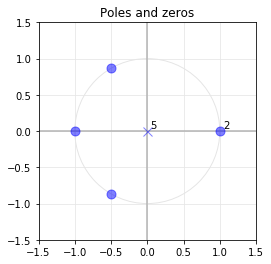

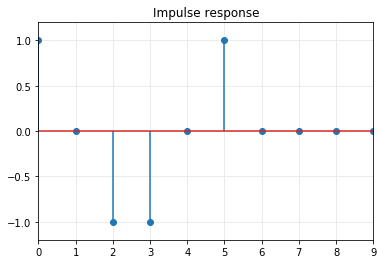

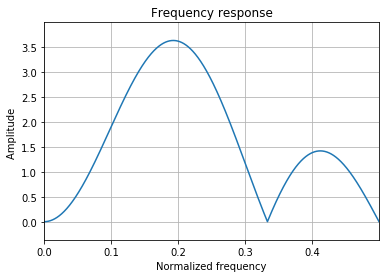

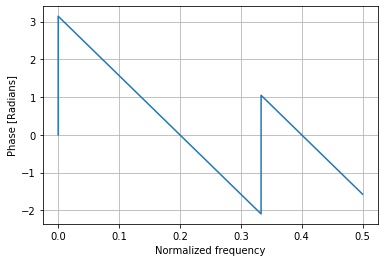

In [29]:
print('premier zéro de coordonnées', 1, 0)
d1=0
print('distance à (1,0) = ', d1)
print('deuxième zéro de coordonnées', -1, 0)
d2=np.sqrt((1-(-1))**2+ 0**2)
print('distance à (1,0) = ', d2)
print('troisieme zero de coordonnees', np.cos(2*np.pi/3), np.sin(2*np.pi/3))
d3=np.sqrt((1-np.cos(2*np.pi/3))**2+ np.sin(2*np.pi/3)**2)
print('distance a (1,0) = ', d3)
print('quatrieme zero de coordonnees', -np.cos(2*np.pi/3), -np.sin(2*np.pi/3))
d4=np.sqrt((1-np.cos(2*np.pi/3))**2+ (-np.sin(2*np.pi/3))**2)
print('distance a (1,0) = ', d4)

print('magnitude = ',d1*d1*d2*d3*d4)


zp=[[1,1,-1, np.exp(1j*2*np.pi/3),np.exp(-1j*2*np.pi/3)],[0,0,0,0,0],[10]] # [[zeroes], [poles], plot figure]

sysplots(np.array(zp[0]),np.array(zp[1]),1,zp[2][0],4)  # (z,p,gain,nimp,numfig)



#### Réponse fréquentielle en magnitude
Commençons par interpréter la troisième figure, qui représente la magnitude de la réponse en fréquence.

Pour vérifiez que cette réponse fréquentielle correspond bien au diagramme des pôles et zéros, reprenons la méthode graphique qui permet d'estimer la magnitude de la réponse fréquentielle.  A la fréquence 0 ($\omega =0$), la magnitude est égale au produit des distances du point (1,0) dans le plan $z$ aux zéros.  Le premier et deuxiéme zéros sont en  (1,0). Le deuxième zéro est aux coordonnées (-1,0) et le troisième et quatrieme sont sur les coordonnées ($\cos(2\pi/3), \sin(2\pi/3)$) et ($\cos(2\pi/3), \sin(-2\pi/3)$) .  
La magnitude est donc égale à d1 * d1 * d2 * d3 * d4 = 0.  Cela correspond bien à la réponse fréquentielle tracée en $f=0$.

La pente à l'origine n'est pas une droite, mais une courbe. Cela correspond à la présence d'un zéro double en (1,0). On peut aussi voir que les valeurs des maximums. Cela correspond à $\omega = \displaystyle \frac{\pi}{3} = 0$, correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.1666$. On peut realise la même procédure pour le deuxième maximum pour un angle $\omega = \displaystyle \frac{5\pi}{3} = 0$, correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.42$
 
De plus, on constate que pour les zéros, leur angle divisé par 2PI correspond bien aux fréquences pour lesquelles la réponse fréquentielle tombe à 0. 


#### Réponse fréquentielle en phase
Comme on l'a vu dans le chapitre sur les systèmes LTI, la réponse impulsionnelle étant symétrique (à un décalage près), la phase de la réponse fréquentielle est linéaire. Ce filtre est un filtre FIR, et tous les filtres FIR ont une phase linéaire, parce que les filtres FIR n’ont que des zéros.

#### Réponse impulsionnelle
On se souvient que la réponse fréquentielle est également la transformée de Fourier (à temps discrèt) de la réponse impulsionnelle du filtre.  La réponse impulsionnelle est donc la DTFT inverse de la réponse fréquentielle.  

On a des variations sur la réponse impulsionnele, Afin de commenter la réponse impulsionnelle, observons la réponse fréquentielle. A l'origine, la droite n'est pas affine, puis la courbe atteint son maximum en f=0,16Hz pour rechuter et avant de légèremment remonter. c'est pour cela que l'on a des dirac de valeur +-1. De plus, on confirme que H(0)=0, validant bien la DTFT. 

### Filtres FIR : Un zéro double en $z=-1$, et deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{ \pi}{3}}$

premier zéro de coordonnées -1 0
distance à (1,0) =  2.0
deuxième zero de coordonnees 0.5000000000000001 0.8660254037844386
distance a (1,0) =  0.9999999999999999
troisieme zero de coordonnees -0.5000000000000001 -0.8660254037844386
distance a (1,0) =  1.7320508075688772
magnitude =  3.999999999999999


/Users/isabelledias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: ComplexWarning: Casting complex values to real discards the imaginary part


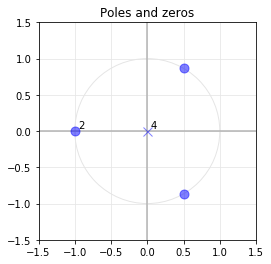

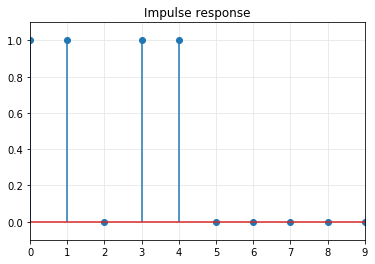

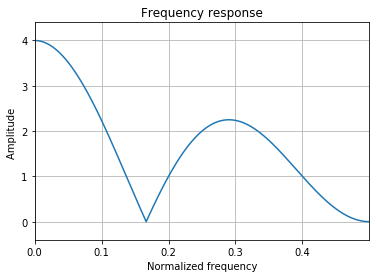

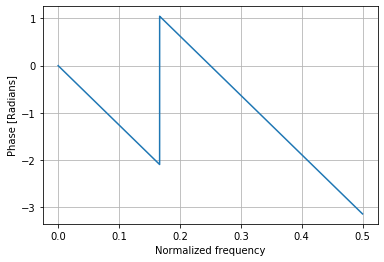

In [36]:
print('premier zéro de coordonnées', -1, 0)
d1=np.sqrt((1-(-1))**2+ 0**2)
print('distance à (1,0) = ', d1)
print('deuxième zero de coordonnees', np.cos(np.pi/3), np.sin(np.pi/3))
d2=np.sqrt((1-np.cos(np.pi/3))**2+ np.sin(np.pi/3)**2)
print('distance a (1,0) = ', d3)
print('troisieme zero de coordonnees', -np.cos(np.pi/3), -np.sin(np.pi/3))
d3=np.sqrt((1-np.cos(np.pi/3))**2+ (-np.sin(np.pi/3))**2)
print('distance a (1,0) = ', d4)

print('magnitude = ',d1*d1*d2*d3)


zp=[[-1,-1,np.exp(1j*np.pi/3),np.exp(-1j*np.pi/3)],[0,0,0,0],[10]] # [[zeroes], [poles], plot figure]

sysplots(np.array(zp[0]),np.array(zp[1]),1,zp[2][0],4)  # (z,p,gain,nimp,numfig)


#### Réponse fréquentielle en magnitude
Commençons par interpréter la troisième figure, qui représente la magnitude de la réponse en fréquence.

Pour vérifiez que cette réponse fréquentielle correspond bien au diagramme des pôles et zéros, reprenons la méthode graphique qui permet d'estimer la magnitude de la réponse fréquentielle.  A la fréquence 0 ($\omega =0$), la magnitude est égale au produit des distances du point (1,0) dans le plan $z$ aux zéros.  Le premier zéro est un double zéro en  (-1,0). Le deuxième ey troisième sont aux les coordonnées ($\cos(\pi/3), \sin(\pi/3)$) et ($\cos(\pi/3), \sin(-\pi/3)$) .  
La magnitude est donc égale à d1 * d1 * d2 * d3 = 4.0.  Cela correspond bien à la réponse fréquentielle tracée en $f=0$.

La pente à l'origine n'est pas une droite, mais une courbe. Cela correspond à la présence d'un zéro double en (-1,0). De plus, Elle s'annule bien en pi/3 et -pi/3.


#### Réponse fréquentielle en phase
Comme on l'a vu dans le chapitre sur les systèmes LTI, la réponse impulsionnelle étant symétrique (à un décalage près), la phase de la réponse fréquentielle est linéaire. Ce filtre est un filtre FIR, et tous les filtres FIR ont une phase linéaire, parce que les filtres FIR n’ont que des zéros.

#### Réponse impulsionnelle
On se souvient que la réponse fréquentielle est également la transformée de Fourier (à temps discrèt) de la réponse impulsionnelle du filtre.  La réponse impulsionnelle est donc la DTFT inverse de la réponse fréquentielle.  

Afin de comprendre la réponse impulsionnelle, on peux pbserver la réponse fréquentielle. Pour f=0, on observe un maximum puis une oscillation les coefficients des diracs sont donc justifiés. L'enveloppe de la réponse impulsionnelle présente de faibles variations comparé au précédent, il s'agit donc d'un filtre passe-bas.

### Filtres FIR : Un zéro simple en $z=-1$, un zéro simple en $z=1$  deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{ \pi}{3}}$, de multiplicité 2 (soit 6 zéros au total)

premier zéro de coordonnées -1 0
distance à (1,0) =  2.0
deuxième zéro de coordonnées 1 0
distance à (1,0) =  0
troisieme zero de coordonnees 0.5000000000000001 0.8660254037844386
distance a (1,0) =  0.9999999999999999
quatrieme zero de coordonnees -0.5000000000000001 -0.8660254037844386
distance a (1,0) =  0.9999999999999999
magnitude =  0.0


/Users/isabelledias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/isabelledias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: ComplexWarning: Casting complex values to real discards the imaginary part


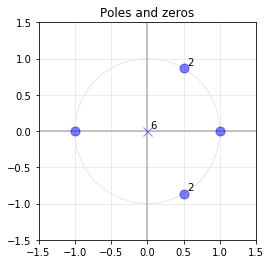

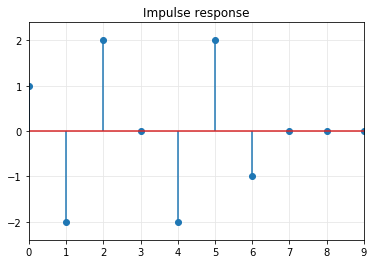

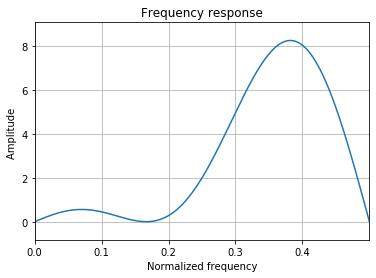

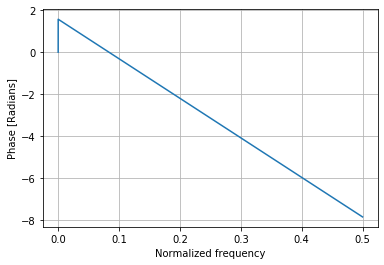

In [39]:
print('premier zéro de coordonnées', -1, 0)
d1=np.sqrt((1-(-1))**2+ 0**2)
print('distance à (1,0) = ', d1)
print('deuxième zéro de coordonnées', 1, 0)
d2=0
print('distance à (1,0) = ', d2)
print('troisieme zero de coordonnees', np.cos(np.pi/3), np.sin(np.pi/3))
d3=np.sqrt((1-np.cos(np.pi/3))**2+ np.sin(np.pi/3)**2)
print('distance a (1,0) = ', d3)
print('quatrieme zero de coordonnees', -np.cos(np.pi/3), -np.sin(np.pi/3))
d4=np.sqrt((1-np.cos(np.pi/3))**2+ (-np.sin(np.pi/3))**2)
print('distance a (1,0) = ', d4)

print('magnitude = ',d1*d2*d3*d3*d4*d4)


zp=[[-1,1, np.exp(1j*np.pi/3),np.exp(1j*np.pi/3), np.exp(-1j*np.pi/3),np.exp(-1j*np.pi/3)],[0,0,0,0,0,0],[10]] # [[zeroes], [poles], plot figure]

sysplots(np.array(zp[0]),np.array(zp[1]),1,zp[2][0],4)  # (z,p,gain,nimp,numfig)




#### Réponse fréquentielle en magnitude
Commençons par interpréter la troisième figure, qui représente la magnitude de la réponse en fréquence.

Pour vérifiez que cette réponse fréquentielle correspond bien au diagramme des pôles et zéros, reprenons la méthode graphique qui permet d'estimer la magnitude de la réponse fréquentielle.  A la fréquence 0 ($\omega =0$), la magnitude est égale au produit des distances du point (1,0) dans le plan $z$ aux zéros.  Le premier zéro est aux coordonnées (-1,0), le deuxième est en (1,0), après ça on a deux zéros complexes conjugués double aux les coordonnées ($\cos(\pi/3), \sin(\pi/3)$) et ($\cos(\pi/3), \sin(-\pi/3)$) .  
La magnitude est donc égale à d1 * d2 * d3 * d3 * d4 * d4 = 0.  Cela correspond bien à la réponse fréquentielle tracée en $f=0$.

De plus, pour le premier zéro double, une valeur nulle à $\displaystyle f = \frac{\omega}{2 \pi} = 0.1666$. 



#### Réponse fréquentielle en phase
Comme on l'a vu dans le chapitre sur les systèmes LTI, la réponse impulsionnelle étant symétrique (à un décalage près), la phase de la réponse fréquentielle est linéaire. Ce filtre est un filtre FIR, et tous les filtres FIR ont une phase linéaire, parce que les filtres FIR n’ont que des zéros.

#### Réponse impulsionnelle
On se souvient que la réponse fréquentielle est également la transformée de Fourier (à temps discrèt) de la réponse impulsionnelle du filtre.  La réponse impulsionnelle est donc la DTFT inverse de la réponse fréquentielle.  

Afin de comprendre la réponse impulsionnelle, on peux pbserver la réponse fréquentielle. Pour f=0, on observe une oscillation minime suivit d'une grande oscillation. Les coefficients des diracs sont donc justifiés. La variation de la réponse impulsionnelle étant rapide, cela implique que le pic est à une fréquence élevée.


### Filtres IIR : Un zéro double en $z=1$, un pôle simple en $z=-0.9$ et deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{2 \pi}{3}}$

premier zéro de coordonnées 1 0
distance à (1,0) =  0
deuxième zero de coordonnees -0.4999999999999998 0.8660254037844388
distance a (1,0) =  1.7320508075688772
troisieme zero de coordonnees 0.4999999999999998 -0.8660254037844388
distance a (1,0) =  1.0000000000000002
premier pôle de coordonnees -0.9
distance a (1,0) =  1.9
magnitude =  0.0


/Users/isabelledias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: ComplexWarning: Casting complex values to real discards the imaginary part


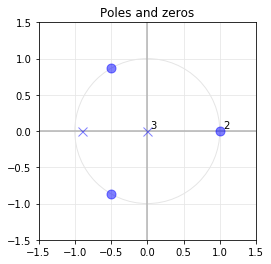

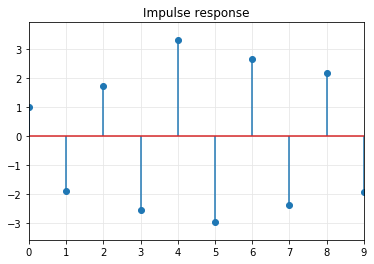

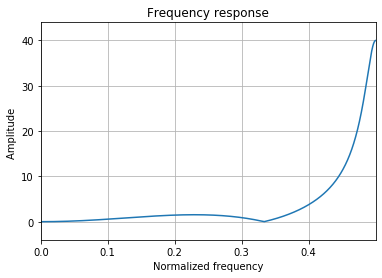

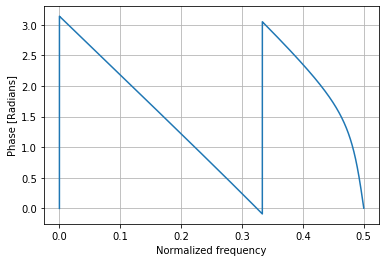

In [33]:
print('premier zéro de coordonnées', 1, 0)
d1=0
print('distance à (1,0) = ', d1)
print('deuxième zero de coordonnees', np.cos(2*np.pi/3), np.sin(2*np.pi/3))
d2=np.sqrt((1-np.cos(2*np.pi/3))**2+ np.sin(2*np.pi/3)**2)
print('distance a (1,0) = ', d2)
print('troisieme zero de coordonnees', -np.cos(2*np.pi/3), -np.sin(2*np.pi/3))
d3=np.sqrt((1-(-np.cos(2*np.pi/3)))**2+ (-np.sin(2*np.pi/3))**2)
print('distance a (1,0) = ', d3)

print('premier pôle de coordonnees', -0.9)
p1=1.9
print('distance a (1,0) = ', p1)

print('magnitude = ',(d1*d1*d2*d3)/p1)


zp=[[1,1, np.exp(1j*2*np.pi/3), np.exp(-1j*2*np.pi/3)],[-0.9,0,0,0],[10]] # [[zeroes], [poles], plot figure]

sysplots(np.array(zp[0]),np.array(zp[1]),1,zp[2][0],4)  # (z,p,gain,nimp,numfig)

#### Réponse fréquentielle en magnitude
Commençons par interpréter la troisième figure, qui représente la magnitude de la réponse en fréquence.

Pour vérifiez que cette réponse fréquentielle correspond bien au diagramme des pôles et zéros, reprenons la méthode graphique qui permet d'estimer la magnitude de la réponse fréquentielle.  A la fréquence 0 ($\omega =0$), la magnitude est égale au produit des distances du point (1,0) dans le plan $z$ aux zéros.  Le premier zéro double est aux les coordonnées (1,0). Le deuxième et le troisième zéros sont sur les coordonnées ($\cos(2\pi/3), \sin(2\pi/3)$) et ($\cos(2\pi/3), \sin(-2\pi/3)$) . On a aussi une pôle simple en z = - 0.9.

La magnitude est égale au produit des distances du point (1,0) dans le plan z aux zéros divisé par le produit des distances du point(1,0) des pôles dans le plan z. La magnitude est donc égale à (d1 * d1 * d2 * d3) / p1 = 0 .  Cela correspond bien à la réponse fréquentielle tracée en $f=0$.  De plus, la présence d'un pôle prés du cercle provoque une forte augmentation.

Toujours en se souvenant que la magnitude est égale au produit des distances du point correspondant à ω dans le plan z aux zéros, pour le second zéro, cela correspond à $\omega = \displaystyle \frac{2\pi}{3} = 0$, correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.3333$. De plus on doit retrouver un pics pour ω=π (pôle), correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.5$. Tout cela correspond bien au tracé fourni.


#### Réponse fréquentielle en phase
On peux bien voir que la réponse fréquentielle est non-linéaire. Tout filtre IIR a une phase non-linéaire. De plus, la présence de pôles proches du cercle confirme bien la non-linéairité de la phase du filtre.

#### Réponse impulsionnelle
On se souvient que la réponse fréquentielle est également la transformée de Fourier (à temps discrèt) de la réponse impulsionnelle du filtre.  La réponse impulsionnelle est donc la DTFT inverse de la réponse fréquentielle.  

Alors, afin de comprendre la réponse impulsionnelle, on peux observer la réponse fréquentielle. La variation de la réponse impulsionnelle étant rapide, cela implique que le pic est à une fréquence élevée.

### Filtres IIR : Un zéro double en $z=-1$, et deux pôles  complexes conjugués en $\displaystyle z=0.9 \, e^{\pm \jmath \frac{ \pi}{3}}$

premier zéro de coordonnées -1 0
distance à (1,0) =  2.0
premier pôle de coordonnees 0.4500000000000001 0.7794228634059948
distance a (1,0) =  0.9886859966642594
deuxième pôle de coordonnees 0.4500000000000001 -0.7794228634059948
distance a (1,0) =  0.9539392014169454
magnitude =  4.241123431539399


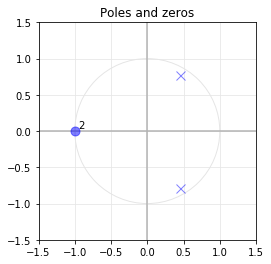

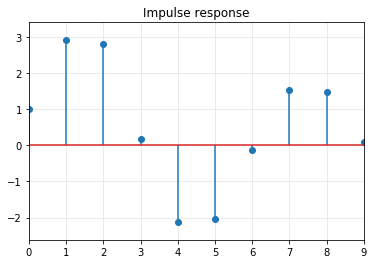

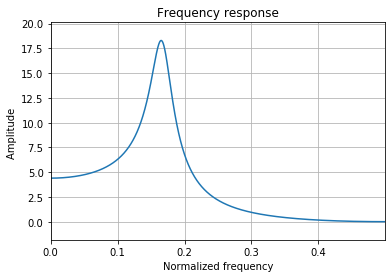

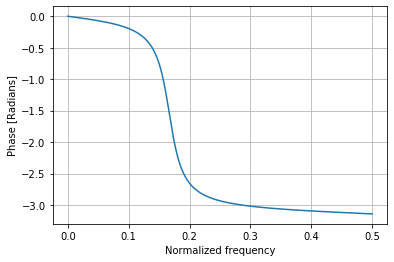

In [40]:
print('premier zéro de coordonnées', -1, 0)
d1=np.sqrt((1-(-1))**2+ 0**2)
print('distance à (1,0) = ', d1)

#pôles
print('premier pôle de coordonnees', 0.9*np.cos(np.pi/3), 0.9*np.sin(np.pi/3))
p1=np.sqrt((1-0.9*np.cos(np.pi/3))**2+ 0.9*np.sin(np.pi/3)**2)
print('distance a (1,0) = ', p1)
print('deuxième pôle de coordonnees', 0.9*np.cos(np.pi/3), -0.9*np.sin(np.pi/3))
p2=np.sqrt((1-0.9*np.cos(np.pi/3))**2+ (-0.9*np.sin(np.pi/3))**2)
print('distance a (1,0) = ', p2)


print('magnitude = ',(d1*d1)/(p1*p2))


zp=[[-1,-1],[0.9*np.exp(1j*np.pi/3), 0.9*np.exp(-1j*np.pi/3)],[10]] # [[zeroes], [poles], plot figure]

sysplots(np.array(zp[0]),np.array(zp[1]),1,zp[2][0],4)  # (z,p,gain,nimp,numfig)

#### Réponse fréquentielle en magnitude
Commençons par interpréter la troisième figure, qui représente la magnitude de la réponse en fréquence.

Pour vérifiez que cette réponse fréquentielle correspond bien au diagramme des pôles et zéros, reprenons la méthode graphique qui permet d'estimer la magnitude de la réponse fréquentielle.  Le premier zéro double est aux les coordonnées (-1,0). 


Le premier et le deuxième pôles sont sur les coordonnées ($0.9\cos(\pi/3), 0.9\sin(\pi/3)$) et ($0.9\cos(\pi/3), 0.8\sin(-\pi/3)$) . 

La magnitude est égale au produit des distances du point (1,0) dans le plan z aux zéros divisé par le produit des distances du point(1,0) des pôles dans le plan z. La magnitude est donc égale à (d1 * d1) / (p1 * p2) = 4.24.  Cela correspond bien à la réponse fréquentielle tracée en $f=0$. De plus, la présence de deux pôles prés du cercle provoque une forte augmentation.

Toujours en se souvenant que la magnitude est égale au produit des distances du point correspondant à ω dans le plan z aux zéros. Pour les zéros, on a une valleur nulle à ω=π, correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.5$. De plus on doit retrouver un pics pour $\omega = \displaystyle \frac{\pi}{3}$ (pôle), correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.166666$. Tout cela correspond bien au tracé fourni.

#### Réponse fréquentielle en phase
On peux bien voir que la réponse fréquentielle est non-linéaire. Tout filtre IIR a une phase non-linéaire. De plus, la présence de pôles proches du cercle confirme bien la non-linéairité de la phase du filtre.

#### Réponse impulsionnelle
On se souvient que la réponse fréquentielle est également la transformée de Fourier (à temps discrèt) de la réponse impulsionnelle du filtre.  La réponse impulsionnelle est donc la DTFT inverse de la réponse fréquentielle.  

Alors, afin de comprendre la réponse impulsionnelle, on peux observer la réponse fréquentielle. Une variation relativement lente de l'enveloppe de la réponse impulsionnelle implique un sommet à une fréquence moyenne. On peux voir cette corrélation entre la réponse impulsionnelle et fréquentielle. 

### Filtres IIR : Un pôle simple en $z=-0.9$, un zéro simple en $z=1$  deux zéros complexes conjugués en $\displaystyle z=e^{\pm \jmath \frac{ \pi}{3}}$,  et deux pôles complexes conjuguées en $\displaystyle z=0.9 \, e^{\pm \jmath \frac{2\pi}{3}}$

premier zéro de coordonnées 1 0
distance à (1,0) =  0
deuxième zero de coordonnees 0.5000000000000001 0.8660254037844386
distance a (1,0) =  0.9999999999999999
troisieme zero de coordonnees -0.5000000000000001 -0.8660254037844386
distance a (1,0) =  1.7320508075688772
premier pôle de coordonnees 0.4500000000000001 0.7794228634059948
distance a (1,0) =  0.9886859966642594
deuxième pôle de coordonnees -0.4500000000000001 -0.7794228634059948
distance a (1,0) =  1.6462077633154328
troisieme pôle de coordonnees -0.9
distance a (1,0) =  1.9
magnitude =  0.0


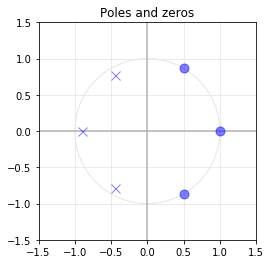

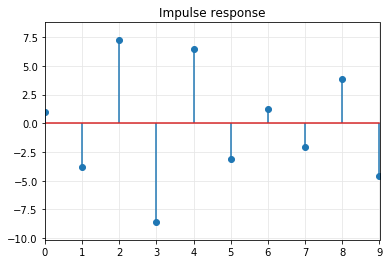

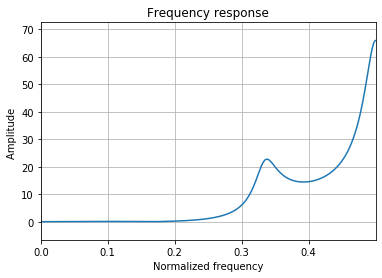

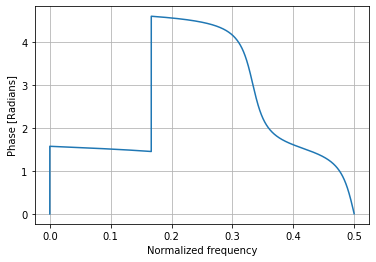

In [34]:
print('premier zéro de coordonnées', 1, 0)
d1=0
print('distance à (1,0) = ', d1)
print('deuxième zero de coordonnees', np.cos(np.pi/3), np.sin(np.pi/3))
d2=np.sqrt((1-np.cos(np.pi/3))**2+ np.sin(np.pi/3)**2)
print('distance a (1,0) = ', d2)
print('troisieme zero de coordonnees', -np.cos(np.pi/3), -np.sin(np.pi/3))
d3=np.sqrt((1-(-np.cos(np.pi/3)))**2+ (-np.sin(np.pi/3))**2)
print('distance a (1,0) = ', d3)



#pôles
print('premier pôle de coordonnees', 0.9*np.cos(np.pi/3), 0.9*np.sin(np.pi/3))
p1=np.sqrt((1-0.9*np.cos(np.pi/3))**2+ 0.9*np.sin(np.pi/3)**2)
print('distance a (1,0) = ', p1)
print('deuxième pôle de coordonnees', -0.9*np.cos(np.pi/3), -0.9*np.sin(np.pi/3))
p2=np.sqrt((1-0.9*np.cos(np.pi/3))**2+ (-0.9*np.sin(np.pi/3))**2)
print('distance a (1,0) = ', p2)

print('troisieme pôle de coordonnees', -0.9)
p3=1.9
print('distance a (1,0) = ', p3)

print('magnitude = ',(d1*d2*d3)/(p1*p2*p3))


zp=[[1,np.exp(1j*np.pi/3), np.exp(-1j*np.pi/3)],[-0.9, 0.9*np.exp(1j*2*np.pi/3), 0.9*np.exp(-1j*2*np.pi/3)],[10]] # [[zeroes], [poles], plot figure]

sysplots(np.array(zp[0]),np.array(zp[1]),1,zp[2][0],4)  # (z,p,gain,nimp,numfig)

#### Réponse fréquentielle en magnitude
Commençons par interpréter la troisième figure, qui représente la magnitude de la réponse en fréquence.

Pour vérifiez que cette réponse fréquentielle correspond bien au diagramme des pôles et zéros, reprenons la méthode graphique qui permet d'estimer la magnitude de la réponse fréquentielle.  A la fréquence 0 ($\omega =0$), la magnitude est égale au produit des distances du point (1,0) dans le plan $z$ aux zéros divisé par le produit des distances du point(1,0) des pôles dans le plan z.  Le premier zéro simple  aux les coordonnées (1,0). Le deuxième et le troisième zéros sont sur les coordonnées ($\cos(\pi/3), \sin(\pi/3)$) et ($\cos(\pi/3), \sin(-\pi/3)$) . 

On a aussi une premiere pôle simple en z = - 0.9. Et le deuxième et troisième pôles sont sur les coordonnées ($0.9\cos(2\pi/3), 0.9\sin(2\pi/3)$) et ($0.9\cos(2\pi/3), 0.8\sin(-2\pi/3)$) . 
 La magnitude est donc égale à (d1 * d2 * d3) / (p1 * p2 * p3) = 0.  Cela correspond bien à la réponse fréquentielle tracée en $f=0$. De plus, la présence de trois pôles prés du cercle provoque une forte augmentation.


Toujours en se souvenant que la magnitude est égale au produit des distances du point correspondant à ω dans le plan z aux zéros. Pour les zéros, on a une valleur nulle à $\omega = \displaystyle \frac{\pi}{3}$, correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.1666$. De plus on doit retrouver un pics pour $\omega = \displaystyle \frac{2\pi}{3}$ (pôle), correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.33333$ et à ω=π, correspondant à $\displaystyle f = \frac{\omega}{2 \pi} = 0.5$. Tout cela correspond bien au tracé fourni.


#### Réponse fréquentielle en phase
On peux bien voir que la réponse fréquentielle est non-linéaire. Tout filtre IIR a une phase non-linéaire. De plus, la présence de pôles proches du cercle confirme bien la non-linéairité de la phase du filtre.

#### Réponse impulsionnelle
On se souvient que la réponse fréquentielle est également la transformée de Fourier (à temps discrèt) de la réponse impulsionnelle du filtre.  La réponse impulsionnelle est donc la DTFT inverse de la réponse fréquentielle.  

Alors, afin de comprendre la réponse impulsionnelle, on peux observer la réponse fréquentielle. On a une variation rapide, cela implique que le pic est à une fréquence élevée constatée à la fréquence f=0,5.